In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from sklearn.feature_selection import mutual_info_regression

[0.179161997773722, 0.1792550886213098, 0.17892672852130787, 0.1793737298940199, 0.17887329766975846, 0.18154151591055978, 0.18089600000693462, 0.18117423373100738, 0.18129616839660745, 0.18192606987447935, 0.18092545946541438, 0.18167728991707666, 0.18128439702943666, 0.1813033584355983, 0.1816032140249284, 0.18264062478449095, 0.18300722648860646, 0.18379466687003276, 0.1834629805456105, 0.1821979621966836, 0.18318122192023445, 0.18349686358621753, 0.18336313682102823, 0.1833359071625269, 0.18511578149423613, 0.1843392433481501, 0.18451520223299234, 0.18484635830928653, 0.18395289324751207, 0.18411233657940596, 0.18609719655019674, 0.18652072086440796, 0.18579759424196496, 0.1857830674362928, 0.1875146063662072, 0.1884627300941455, 0.1888916803865497, 0.18958174778729475, 0.19052816380619575, 0.19010034668866993, 0.19113353980287595, 0.19194238029583754, 0.19101560701252307, 0.19161208126008056, 0.1925172177172696, 0.1924584418380313, 0.1941789865928243, 0.19377388337244472, 0.193146

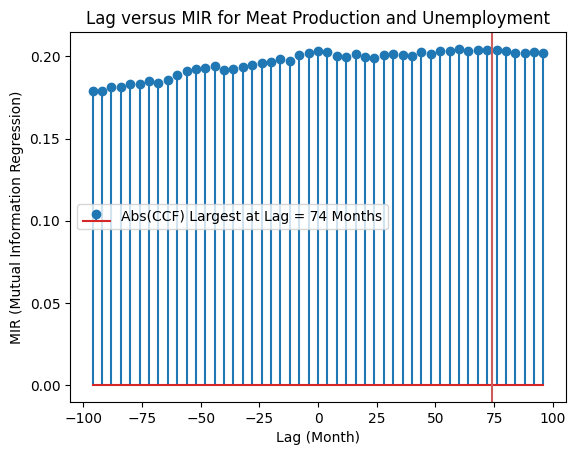

In [7]:
production_df = pd.read_csv('../cleaned-datasets/Cleaned_Meat_Stats_Meat_Production.csv')
economic_df = pd.read_csv('../cleaned-datasets/interpolated_economic_data.csv')
economic_df['Date'] = economic_df['date']

# Averaging data from top meatpacking and poultry processing states into one data point per year
condition_1_states = ["Nebraska", "Iowa", "Texas", "Kansas", "Illinois"]
condition_1 = economic_df["state"].isin(condition_1_states)
condition_2_states = ["Georgia", "Arkansas", "North Carolina", "Alabama", "Mississippi"]
condition_2 = economic_df['state'].isin(condition_2_states)
new_economic_df = economic_df[condition_1 | condition_2].copy()

# Merge datasets on 'Year'
data = pd.merge(production_df, new_economic_df, on='Date')
data.set_index('Date')

# Create an array of lag values
num = 96
lags = np.arange(-num, num + 1)

# aux fn for application
def gen_corr(l1, l2, lag: int) -> float:
    # Positive shift means front becomes NaN, negative shift means end becomes NaN
    if lag < 0:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[:len(shifted_l1)] # align l2 to be the same length as l1
    else:
        shifted_l1 = l1.copy().shift(-lag).dropna() 
        aligned_l2 = l2[lag:]
        aligned_l2 = aligned_l2[:len(shifted_l1)] # Just in case?
        
    return mutual_info_regression(shifted_l1.values.reshape(-1, 1), aligned_l2.values)[0]
    
    # return mutual_info_regression(
    #     l1.shift(lag).dropna().values.reshape(-1, 1), l2.values[:-lag]
    # )
    
# generate correlations
# corr = [gen_corr(data['unemployment_rate'], data['Production'], -lag) for lag in lags if lag <= 0]
# corr += [gen_corr(data['Production'], data['unemployment_rate'], lag) for lag in lags if lag > 0]
corr = [gen_corr(data['unemployment_rate'], data['Production'], lag) for lag in lags]

# # Calculating cross-correlation for negative lags
# neg_ccf = ccf(data['unemployment_rate'], data['Production'])
# neg_ccf = neg_ccf[:num + 1][::-1]

# # Combine with non-negative lags
# pos_ccf = ccf(data['Production'], data['unemployment_rate'])
# all_ccf = list(neg_ccf) + list(pos_ccf[1:num + 1])

all_ccf = corr

print(all_ccf)

max_index = 0
for i in range(0, len(all_ccf)):
    if abs(all_ccf[i]) > abs(all_ccf[max_index]):
        max_index = i
print(max_index - num, all_ccf[max_index])

# Slice the arrays to make the graph less overwhelming
lags_sliced = lags[::4]
ccf_sliced = all_ccf[::4]

plt.stem(lags_sliced, ccf_sliced, label=f'Abs(CCF) Largest at Lag = {max_index - num} Months')
plt.xlabel('Lag (Month)')
plt.ylabel('MIR (Mutual Information Regression)')
plt.axvline(x=max_index - num, color="indianred")
# plt.ylim(-0.12, -0.08)
# plt.yticks(np.arange(-0.11, -0.08, 0.01)) # set y-axis ticks at intervals
plt.title('Lag versus MIR for Meat Production and Unemployment')
plt.legend()
plt.savefig('../visualizations/Lag Correlation Coefficients - MIR.png', dpi=400)
plt.show()